In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
sns.set()

In [3]:
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions = False)
data.drop(['Open','High','Low','Volume'],axis=1, inplace=True)
data = data.droplevel(0,axis=1).resample('M').last()

[*********************100%***********************]  9 of 9 completed
/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_31110/1473613618.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.droplevel(0,axis=1).resample('M').last()


In [5]:
rets = data.pct_change().fillna(0)

In [7]:
pal = sns.color_palette('Spectral', len(tickers))

## Risk Parity PF

In [11]:
#cov mat
cov = rets.cov()*12
noa = rets.shape[1]
init_guess = np.repeat(1/noa,noa)

#wegith bound
bounds = ((0.1,1.0),)*noa

#constraint
weights_sum_to_1 = {'type':'eq',
                    'fun': lambda weights : np.sum(weights)-1}

#target : target risk : equal 
# 이것을 마음대로 20프로 이런식으로 정의할수 있음. 이번엔 그냥 1/n
target_risk = np.repeat(1/noa, noa)

# sub function : minimize target_risk and err
def msd_risk(weights, target_risk, cov):
    port_var = weights.T @ cov @ weights 
    marginal_contribs = cov @ weights #각 자산들의 한계 기여도
    risk_contribs = np.multiply(marginal_contribs, weights.T)/port_var
    return((risk_contribs-target_risk)**2).sum()
# 리스크 버젯팅은: 자산의 가중치를 조절해서 그 자산들이 전체 포트폴리오에 위험 기여도를, 
# 실제 미리 지정해 놓은 위험예산과 match시키는것. 

# weight
res = minimize(msd_risk,
               init_guess,
               args=(target_risk,cov),
               method='SLSQP',
               constraints=(weights_sum_to_1),
               bounds =bounds)

weights= res.x

In [13]:
# RP
weights_df = pd.Series(np.round(weights, 4), index=tickers)
weights_df = weights_df[weights_df > 0.0]


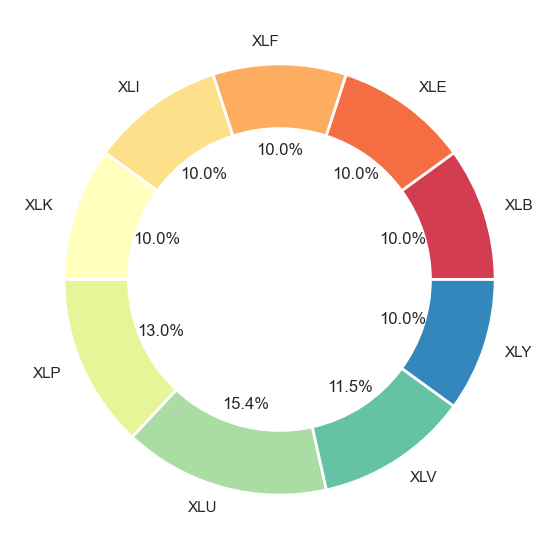

In [14]:
plt.figure(figsize=(7,7))
wedgeprops = {'width':0.3, 'edgecolor':'w', 'linewidth':2}
plt.pie(weights_df, labels=weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [15]:
# 리스크 패리티 포트폴리오 가중치 계산 함수
def get_rp_weights(cov):

    # 자산 개수
    noa = cov.shape[0]

    # 초기 가중치값
    init_guess = np.repeat(1/noa, noa)

    # 제약조건 및 상하한값
    bounds=((0.0, 1.0), ) * noa
    weights_sum_to_1 = {'type':'eq',
                        'fun': lambda weights: np.sum(weights) - 1}

    # 자산별 목표위험 예산 (1/N)
    target_risk = np.repeat(1/noa, noa)

    # 목적함수: 타겟 위험 예산과 자산별 위험 기여도 간의 괴리
    def msd_risk(weights, target_risk, cov):
        port_var = weights.T @ cov @ weights
        marginal_contribs = cov @ weights

        risk_contribs = np.multiply(marginal_contribs, weights.T) / port_var

        return ((risk_contribs - target_risk) ** 2).sum()

    # 최적화 수행
    res = minimize(msd_risk,
                   init_guess,
                   args=(target_risk, cov),
                   method='SLSQP',
                   constraints=(weights_sum_to_1),
                   bounds=bounds)
    
    return res.x

In [16]:
# 빈 데이터프레임 생성
rp_w_df = pd.DataFrame().reindex_like(rets)

# 공분산행렬의 3차원 배열 생성
cov = rets.rolling(12).cov().fillna(0) * 12
cov = cov.values.reshape(int(cov.shape[0] / cov.shape[1]), cov.shape[1], cov.shape[1])

# RP 가중치 산출
for i in range(12, len(rp_w_df)):
    rp_w_df.iloc[i] = get_rp_weights(cov[i-1])

Text(0, 0.5, 'Returns')

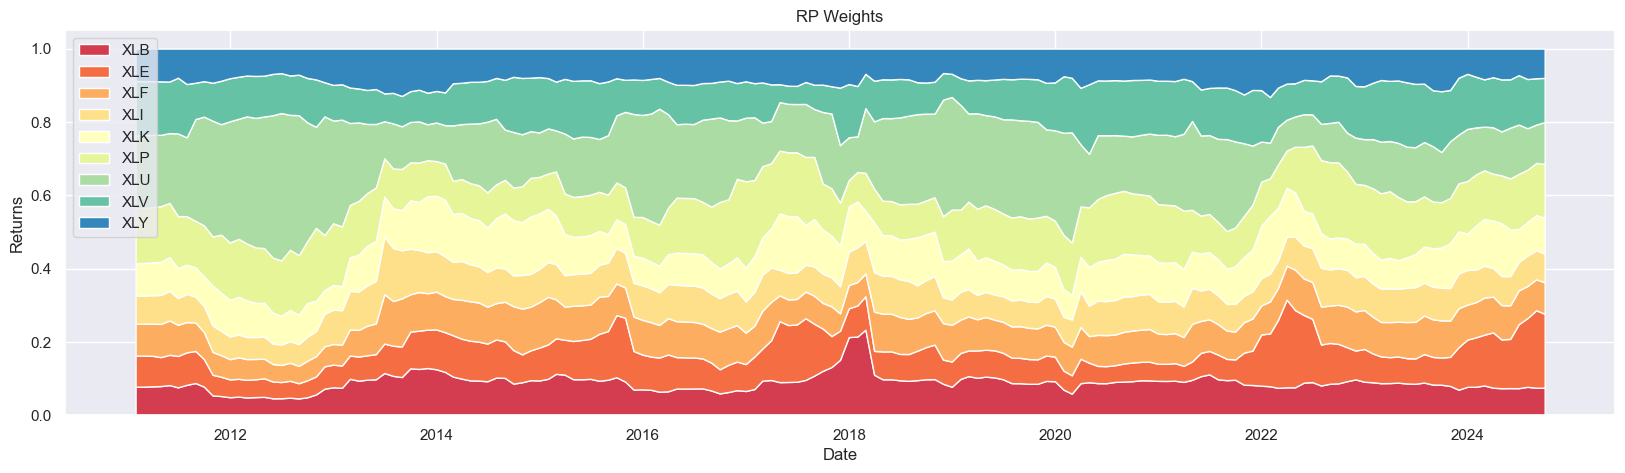

In [17]:
# 시계열 플랏 시각화
plt.figure(figsize=(20, 5))
plt.stackplot(rp_w_df.index, rp_w_df.T, labels=rp_w_df.columns, colors=pal)
plt.legend(loc='upper left')
plt.title('RP Weights')
plt.xlabel('Date')
plt.ylabel('Returns')

Text(0, 0.5, 'Returns')

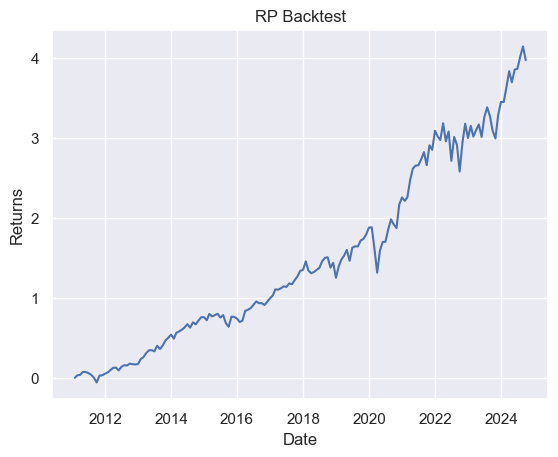

In [18]:
# RP 포트폴리오 수익률
port_rets = rp_w_df.shift() * rets
port_cum_rets = (1 + port_rets.sum(axis=1)).cumprod() - 1

# 백테스팅 시각화
plt.plot(port_cum_rets.iloc[12:])
plt.title('RP Backtest')
plt.xlabel('Date')
plt.ylabel('Returns')